In [1]:
# imports
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from esem import gp_model
from eofs.xarray import Eof
from utils_first_layer import *
from utils import *
import gpflow

2025-02-08 15:39:29.840229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739054369.858875   45697 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739054369.864865   45697 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 15:39:29.886477: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare Data

In [2]:
train_files= ['ssp126', 'ssp585', 'historical']

In [3]:
# get data
Xtrain, eof_solvers = create_predictor_data(train_files)

In [4]:
Ytrain = get_Ytrain(train_files)
Ytrain_yield = Ytrain['mai'].values.reshape(-1, 360*720)

In [5]:
Xtest = get_test_data('ssp370', eof_solvers)

In [6]:
Ytest = get_Ytest('ssp370')
yield_truth = Ytest['mai']

In [7]:
train_nan_mask = Xtrain.isna().any(axis=1).values
Xtrain = Xtrain.dropna(axis=0, how='any')
Ytrain_yield = Ytrain_yield[~train_nan_mask]
assert Xtrain.shape[0]==Ytrain_yield.shape[0]

In [8]:
test_nan_mask = Xtest.isna().any(axis=1).values
Xtest = Xtest.dropna(axis=0, how='any')
yield_truth = yield_truth[~test_nan_mask]

In [9]:
mask_all_nan_by_col = np.isnan(Ytrain_yield).all(axis=0)

In [10]:
Ytrain_yield_dropped = Ytrain_yield[:, ~mask_all_nan_by_col]

In [11]:
np.isnan(Ytrain_yield_dropped).sum()

13205

In [12]:
Y_imputed = np.nan_to_num(Ytrain_yield_dropped, nan=0.0)

## Model

In [13]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0]) # active_dims specifies which dimension the kernel is applied to
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

I0000 00:00:1739054383.764261   45697 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15452 MB memory:  -> device: 0, name: Quadro GP100, pci bus id: 0000:18:00.0, compute capability: 6.0


In [14]:
np.random.seed(5)

"""
In Gaussian Processes, a mean function represents the "prior mean" or the expected value
of the function at any input point before observing any data. By default, this mean is 
zero, but here a constant mean is set.
"""
mean = gpflow.mean_functions.Constant()

model = gpflow.models.GPR(data=(Xtrain.astype(np.float64), # cast to float64 because gpflow requires numerical stability
                                Y_imputed.astype(np.float64)),
                          kernel = kernel,
                          mean_function = mean)

In [15]:
# define optimizer
optimizer = gpflow.optimizers.Scipy()

# train
optimizer.minimize(model.training_loss,
                   variables=model.trainable_variables,
                   options=dict(disp=True, maxiter=5000))

I0000 00:00:1739054388.942303   45739 cuda_solvers.cc:178] Creating GpuSolver handles for stream 0x55dd38b449e0


  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 18979169.29433634
        x: [ 1.547e+00  1.703e+00 ... -1.120e+00  2.140e+00]
      nit: 265
      jac: [ 6.781e+01 -5.500e+01 ...  1.976e+02  5.078e+01]
     nfev: 336
     njev: 336
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>

## Prediction

In [16]:
# predict
posterior_mean, posterior_var = model.predict_y(Xtest.values) # predicted mean of GP, predicted variance of GP
posterior_stddev = np.sqrt(posterior_var)

posterior_yield_mean_full = np.full((Xtest.shape[0], Ytrain_yield.shape[1]), np.nan)  # fill with NaN
posterior_yield_mean_full[:, ~mask_all_nan_by_col] = posterior_mean

posterior_yield_stddev_full = np.full((Xtest.shape[0], Ytrain_yield.shape[1]), np.nan)  # fill with NaN
posterior_yield_stddev_full[:, ~mask_all_nan_by_col] = posterior_stddev

In [17]:
# put output back into xarray format for calculating RMSE/plotting
posterior_yield = np.reshape(posterior_yield_mean_full, [yield_truth.shape[0], 360, 720])
posterior_yield_stddev = np.reshape(posterior_yield_stddev_full, [yield_truth.shape[0], 360, 720])

posterior_yield_data = xr.DataArray(posterior_yield, dims=yield_truth.dims, coords=yield_truth.coords)
posterior_yield_std_data = xr.DataArray(posterior_yield_stddev, dims=yield_truth.dims, coords=yield_truth.coords)

In [18]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(yield_truth[35], posterior_yield_data[35])}")
print(f"RMSE at 2100: {get_rmse(yield_truth[85], posterior_yield_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(yield_truth[30:41], posterior_yield_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(yield_truth[75:], posterior_yield_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(yield_truth[35:], posterior_yield_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(yield_truth[-20:].mean(dim='time'), posterior_yield_data[-20:].mean(dim='time'))}")

RMSE at 2050: 0.5647865578924279
RMSE at 2100: 0.6152835461507851
RMSE 2045-2055: 0.5522607355115506
RMSE 2090-2100: 0.5375165768231636
RMSE 2050-2100: 0.5518842932262478
RMSE average last 20y: 0.16028293121676235


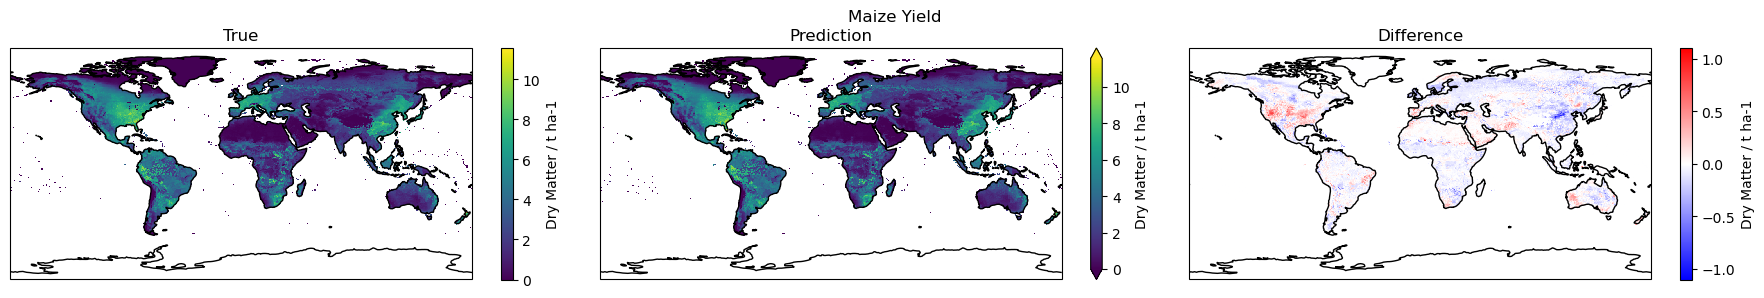

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors

truth_mean = yield_truth.sel(time=slice(2050,None)).mean('time')
posterior_mean = posterior_yield_data.sel(time=slice(2050,None)).mean('time')
difference = truth_mean - posterior_mean

tmin, tmax = float(truth_mean.min()), float(truth_mean.max())
pmin, pmax = float(posterior_mean.min()), float(posterior_mean.max())
dmin, dmax = float(difference.min()), float(difference.max())


buffer = 0.001
vmin = tmin - buffer
vmax = tmax + buffer


abs_max_diff = max(abs(dmin), abs(dmax))
diffnorm = colors.TwoSlopeNorm(vcenter=0., vmin=-abs_max_diff, vmax=abs_max_diff)

# Plot
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18,3))
fig.suptitle('Maize Yield')

# 1) Truth
ax1 = plt.subplot(131, projection=proj)
truth_mean.plot(
    ax=ax1, cmap="viridis",
    vmin=vmin, vmax=vmax,
    cbar_kwargs={"label":"Dry Matter / t ha-1"}
)
ax1.coastlines()
ax1.set_title('True')

# 2) Posterior
ax2 = plt.subplot(132, projection=proj)
posterior_mean.plot(
    ax=ax2, cmap="viridis",
    vmin=vmin, vmax=vmax,
    cbar_kwargs={"label":"Dry Matter / t ha-1"}
)
ax2.coastlines()
ax2.set_title('Prediction')

# 3) Difference
ax3 = plt.subplot(133, projection=proj)
difference.plot(
    ax=ax3, cmap="bwr",
    norm=diffnorm,
    cbar_kwargs={"label":"Dry Matter / t ha-1"}
)
ax3.coastlines()
ax3.set_title('Difference')

plt.tight_layout()
plt.show()


In [20]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[2.13964]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.87055
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.74032
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,2.82581
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,26.67017
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.01313365937432317
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[11.342, 0.07694568, 18.12657..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.09872097451866851
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[6.90542, 12.48067, 17.90294..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.2823349398472347
